In [1]:
import os, gc, torch, PIL, pickle

import pandas as pd
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from utils.plot import plot_losses, plot_train_val_ap_ars
from PIL import Image
from models.load import get_model_label, get_model_name, get_current_epoch, get_dataset_label, get_trained_model

from data.constants import XAMI_MIMIC_PATH, DEFAULT_REFLACX_LABEL_COLS

import utils.print as print_f
from utils.init import reproducibility, clean_memory_get_device

# from models.load import TrainedModels
## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [3]:
from enum import Enum

class TrainedModels(Enum):

    without_clinical = "val_ar_0_5377_ap_0_2981_test_ar_0_4515_ap_0_2716_epoch30_WithoutClincal_05-02-2022 12-32-56_without_clinical"

    # without_clinical_final = "val_ar_0_5053_ap_0_2754_test_ar_0_4265_ap_0_2605_epoch100_WithoutClincal_05-02-2022 14-17-08_without_clinical"

    with_clinical_lr3_200 = "val_ar_0_7222_ap_0_4626_test_ar_0_6727_ap_0_4956_epoch111_WithClincal_05-03-2022 20-39-41_ov_12"

    # with_clinical_lr3_200_final = "val_ar_0_6650_ap_0_3870_test_ar_0_6604_ap_0_4493_epoch200_WithClincal_05-03-2022 23-04-30_ov_12"

    # without_clinical = "val_ar_0_5377_ap_0_2981_test_ar_0_4515_ap_0_2716_epoch30_WithoutClincal_05-02-2022 12-32-56_without_clinical"
    # # with_clinical = "val_ar_0_7430_ap_0_5567_test_ar_0_7974_ap_0_5392_epoch29_WithClincal_05-02-2022 17-07-17_with_clinical"
    
    # with_clinical_lr3_200 = "val_ar_0_7222_ap_0_4626_test_ar_0_6727_ap_0_4956_epoch111_WithClincal_05-03-2022 20-39-41_ov_12"

    # # with_clinical_final = "val_ar_0_7269_ap_0_4601_test_ar_0_6710_ap_0_4286_epoch100_WithClincal_05-02-2022 19-03-30_with_clinical"

    # # without_clinical_final = "val_ar_0_5053_ap_0_2754_test_ar_0_4265_ap_0_2605_epoch100_WithoutClincal_05-02-2022 14-17-08_without_clinical"

    
    CXR_Clinical_ap = "val_ar_0_9381_ap_0_6945_test_ar_0_8224_ap_0_6378_epoch20_WithClincal_05-16-2022 18-13-10_CXR+Clinical"
    CXR_Clinical_final = "val_ar_0_9556_ap_0_6776_test_ar_0_7849_ap_0_6534_epoch71_WithClincal_05-16-2022 19-38-03_CXR+Clinical"

    CXR_ap = "val_ar_0_7518_ap_0_5042_test_ar_0_5388_ap_0_3255_epoch22_WithoutClincal_05-16-2022 20-18-25_CXR"
    CXR_final = "val_ar_0_5966_ap_0_4046_test_ar_0_5388_ap_0_3893_epoch54_WithoutClincal_05-16-2022 21-10-18_CXR"



In [4]:
naming_map = {
    # TrainedModels.with_clinical: "with_clinical_best",
    # TrainedModels.with_clinical_final: "with_clinical_final",
    TrainedModels.CXR_ap: "CXR_ap",
    TrainedModels.CXR_final: "CXR",
    # TrainedModels.without_clinical_final: "without_clinical_final",
    TrainedModels.CXR_Clinical_ap: "CXR+Clinical ap",
    TrainedModels.CXR_Clinical_final: "CXR+Clinical"
}


In [5]:
def get_thrs_evaluation_df(
    models: List[TrainedModels], dataset, disease="all", iobb_thrs=0.5, score_thrs=0.05
):
    all_models_eval_data = {}
    for select_model in models:
        with open(
            os.path.join(
                "eval_results",
                f"{select_model.value}_{dataset}_{disease}_score_thrs{score_thrs}.pkl",
            ),
            "rb",
        ) as f:
            eval_data = pickle.load(f)
            all_models_eval_data[select_model.value] = eval_data

    return pd.DataFrame(
        [
            {
                "model": str(select_model).split(".")[-1],
                **all_models_eval_data[select_model.value][iobb_thrs][0],
            }
            for select_model in models
        ]
    )[["model", "ap", "ar"]]



In [6]:
# # from models.load import TrainedModels
# from typing import List

# def plot_iou_result_old(models: List[TrainedModels] , datasets, disease="all", figsize=(10, 10), include_recall=False):

#     cm = plt.get_cmap('rainbow')
#     NUM_COLORS = len(models)

#     all_models_eval_data = {}
#     for select_model in models:
#         with open(
#             os.path.join(
#                 "eval_results",
#                 f"{select_model.value}_{datasets}_{disease}.pkl",
#             ),
#             "rb",
#         ) as f:
#             eval_data = pickle.load(f)
#             all_models_eval_data[select_model.value] = eval_data


#     fig, (precision_ax, recall_ax) = plt.subplots(
#         2, figsize=figsize, dpi=80, sharex=True,
#     )

#     fig.suptitle(f"{datasets}")

#     precision_ax.set_title("Average Precision")
#     precision_ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

#     for select_model in models:
#         precision_ax.plot(
#             all_models_eval_data[select_model.value].keys(),
#             [v[0]["ap"] for v in all_models_eval_data[select_model.value].values()],
#             marker="o",
#             label=get_model_label(select_model, naming_map=naming_map),
#             # color="darkorange",
#         )
#     precision_ax.legend(loc="upper right")

#     recall_ax.set_title("Average Recall")
#     recall_ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    
#     for select_model in models:
#         recall_ax.plot(
#             all_models_eval_data[select_model.value].keys(),
#             [v[0]["ar"] for v in all_models_eval_data[select_model.value].values()],
#             marker="o",
#             label=get_model_label(select_model, naming_map=naming_map),
#             # color="darkorange",
#         )

#     recall_ax.legend(loc="upper right")
#     recall_ax.set_xlabel("IoBB")

#     plt.plot()
#     plt.pause(0.01)

#     return fig

In [7]:
# from models.load import TrainedModels
from typing import List

def plot_iou_result(
    models: List[TrainedModels],
    datasets,
    disease="all",
    figsize=(10, 10),
    include_recall=False,  
    score_thrs=0.05,
):

    cm = plt.get_cmap("rainbow")
    NUM_COLORS = len(models)

    all_models_eval_data = { dataset: {} for dataset in datasets}

    for select_model in models:
        for dataset in datasets:
            with open(
                os.path.join(
                    "eval_results", f"{select_model.value}_{dataset}_{disease}_score_thrs{score_thrs}.pkl",
                ),
                "rb",
            ) as f:
                eval_data = pickle.load(f)
                all_models_eval_data[dataset][select_model.value] = eval_data

    fig, axes = plt.subplots(
        len(datasets), 2 if include_recall else 1,
        figsize=figsize,
        dpi=80,
        sharex=True,
        squeeze=False
    )

    for i, dataset in enumerate(datasets):
        axes[i,0].set_title(f"[{dataset}] - Average Precision")
        axes[i,0].set_prop_cycle(
            "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
        )

        for select_model in models:
            axes[i,0].plot(
                all_models_eval_data[dataset][select_model.value].keys(),
                [v[0]["ap"] for v in all_models_eval_data[dataset][select_model.value].values()],
                marker="o",
                label=get_model_label(select_model, naming_map=naming_map),
                # color="darkorange",
            )
        axes[i,0].legend(loc="lower left")

        if (include_recall):

            axes[i, 1].set_title(f"[{dataset}] - Average Recall")
            axes[i, 1].set_prop_cycle(
                "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
            )

            for select_model in models:
                axes[i, 1].plot(
                    all_models_eval_data[dataset][select_model.value].keys(),
                    [v[0]["ar"] for v in all_models_eval_data[dataset][select_model.value].values()],
                    marker="o",
                    label=get_model_label(select_model, naming_map=naming_map),
                    # color="darkorange",
                )

            axes[i, 1].legend(loc="lower left")
            axes[i, 1].set_xlabel("IoBB")

    plt.plot()
    plt.pause(0.01)

    return fig


In [8]:
def showModelOnDatasets(
    select_model, datasets, disease="all", figsize=(10, 10), include_recall=False,
    score_thrs=0.05,
):
    """
    This function used for detecting the overfitting dataset.    
    """
    cm = plt.get_cmap("gist_rainbow")
    NUM_COLORS = len(datasets)

    all_models_eval_data = {}
    for dataset in datasets:
        with open(
            os.path.join(
                "eval_results", f"{select_model.value}_{dataset}_{disease}_score_thrs{score_thrs}.pkl",
            ),
            "rb",
        ) as f:
            eval_data = pickle.load(f)
            all_models_eval_data[dataset] = eval_data

    fig, axes = plt.subplots(
        2 if include_recall else 1, figsize=figsize, dpi=80, sharex=True, squeeze=False,
    )

    axes = axes[0]

    fig.suptitle(get_model_label(select_model, naming_map=naming_map))

    axes[0].set_title("Average Precision")
    axes[0].set_prop_cycle(
        "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
    )

    for dataset in datasets:
        axes[0].plot(
            all_models_eval_data[dataset].keys(),
            [v[0]["ap"] for v in all_models_eval_data[dataset].values()],
            marker="o",
            label=dataset,
            # color="darkorange",
        )
    axes[0].legend(loc="lower left")

    if include_recall:
        axes[1].set_title("Average Recall")
        axes[1].set_prop_cycle(
            "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
        )

        for dataset in datasets:
            axes[1].plot(
                all_models_eval_data[dataset].keys(),
                [v[0]["ar"] for v in all_models_eval_data[dataset].values()],
                marker="o",
                label=dataset,
                # color="darkorange",
            )

        axes[1].legend(loc="lower left")
        axes[1].set_xlabel("IoBB")

    plt.plot()
    plt.pause(0.01)

    return fig


In [20]:
def showModelOnScoreThrs(
    select_model: TrainedModels, dataset: str, disease="all", figsize=(10, 10), include_recall=False,
    score_thresholds=[0.5, 0.3, 0.2, 0.1, 0.05],
):
    """
    This function used for detecting the overfitting dataset.    
    """
    cm = plt.get_cmap("gist_rainbow")
    NUM_COLORS = len(score_thresholds)

    all_models_eval_data = {}
    for score_thrs in score_thresholds:
        with open(
            os.path.join(
                "eval_results", f"{select_model.value}_{dataset}_{disease}_score_thrs{score_thrs}.pkl",
            ),
            "rb",
        ) as f:
            eval_data = pickle.load(f)
            all_models_eval_data[score_thrs] = eval_data

    fig, axes = plt.subplots(
        2 if include_recall else 1, figsize=figsize, dpi=80, sharex=True, squeeze=False,
    )

    axes = axes[0]

    fig.suptitle(get_model_label(select_model, naming_map=naming_map))

    axes[0].set_title("Average Precision")
    axes[0].set_prop_cycle(
        "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
    )

    for score_thrs in score_thresholds:
        axes[0].plot(
            all_models_eval_data[score_thrs].keys(),
            [v[0]["ap"] for v in all_models_eval_data[score_thrs].values()],
            marker="o",
            label=f"score_thrs={str(score_thrs)}",
            # color="darkorange",
        )
    axes[0].legend(loc="lower left")

    if include_recall:
        axes[1].set_title("Average Recall")
        axes[1].set_prop_cycle(
            "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
        )

        for score_thrs in score_thresholds:
            axes[1].plot(
                all_models_eval_data[score_thrs].keys(),
                [v[0]["ar"] for v in all_models_eval_data[score_thrs].values()],
                marker="o",
                label=f"score_thrs={str(score_thrs)}",
                # color="darkorange",
            )

        axes[1].legend(loc="lower left")
        axes[1].set_xlabel("IoBB")

    plt.plot()
    plt.pause(0.01)

    return fig


In [10]:
def plot_training_progress(trained_models):
    for trained_model in trained_models:
        _, train_info, _ = get_trained_model(
            trained_model,
            DEFAULT_REFLACX_LABEL_COLS,
            device,
            rpn_nms_thresh=0.3,
            box_detections_per_img=10,
            box_nms_thresh=0.2,
            rpn_score_thresh=0.0,
            box_score_thresh=0.05,
        )

        print_f.print_title("Training Info")
        print(train_info)

        plot_train_val_ap_ars(
            train_ap_ars=train_info.train_ap_ars, val_ap_ars=train_info.val_ap_ars,
        )

        plot_losses(train_info.train_data, train_info.val_data)


In [11]:
from utils.train import num_params

def print_num_params(trained_models):
    for trained_model in trained_models:
        model, train_info, _ = get_trained_model(
            trained_model,
            DEFAULT_REFLACX_LABEL_COLS,
            device,
            image_size=512,
            rpn_nms_thresh=0.3,
            box_detections_per_img=10,
            box_nms_thresh=0.2,
            rpn_score_thresh=0.0,
            box_score_thresh=0.05,
        )

        print(f"| [{train_info.model_setup.name}] | #Params: [{num_params(model):,}] |")


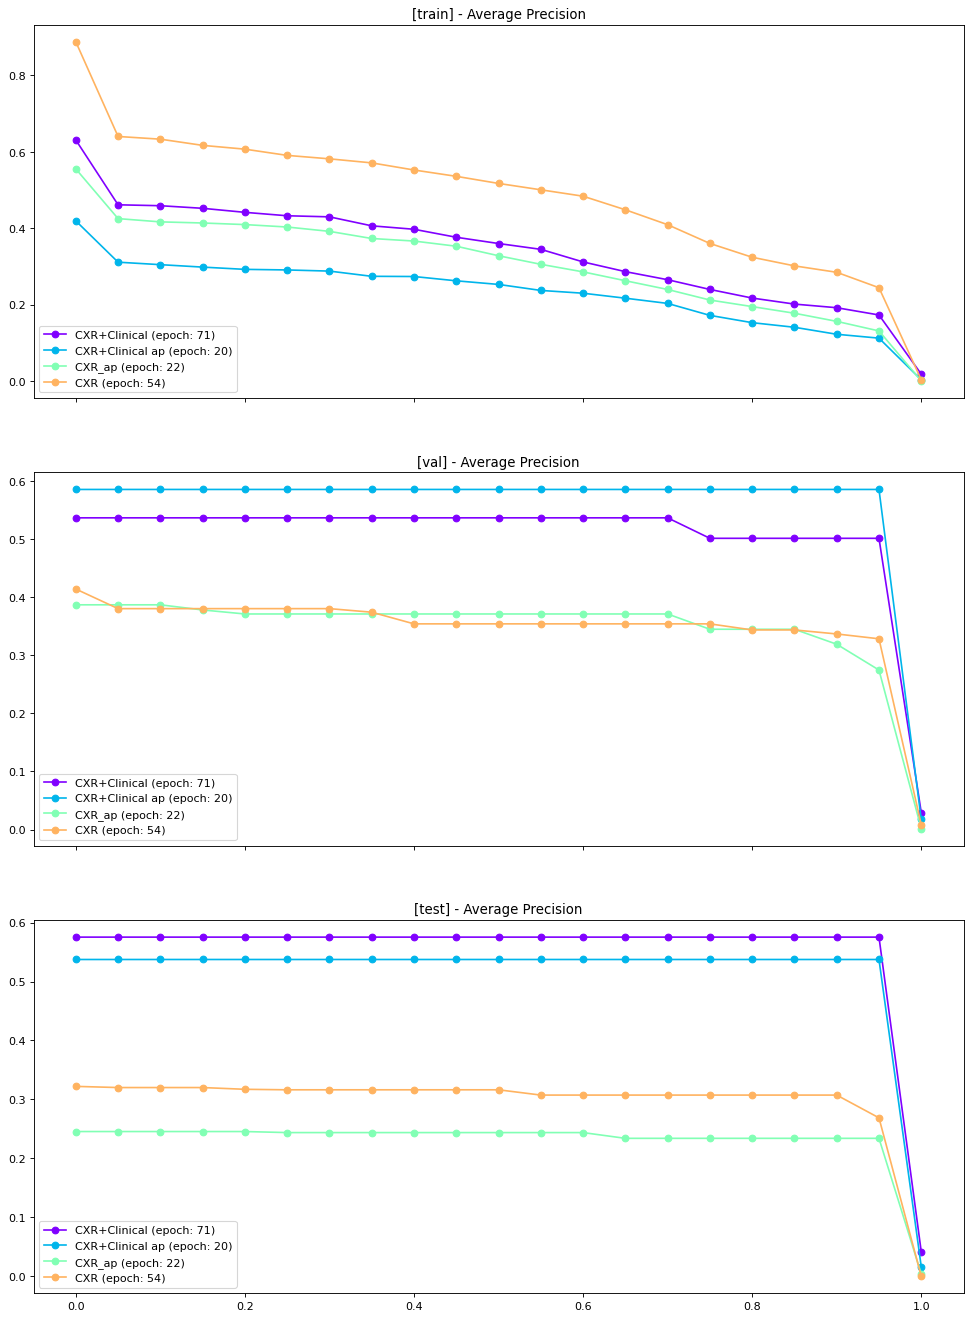

In [12]:
_ = plot_iou_result(
    [
        TrainedModels.CXR_Clinical_final,
        TrainedModels.CXR_Clinical_ap,
        TrainedModels.CXR_ap,
        TrainedModels.CXR_final,
    ],
    ["train", "val", "test"],
    figsize=(15, 21),
    include_recall=False,
    score_thrs=0.3,
)

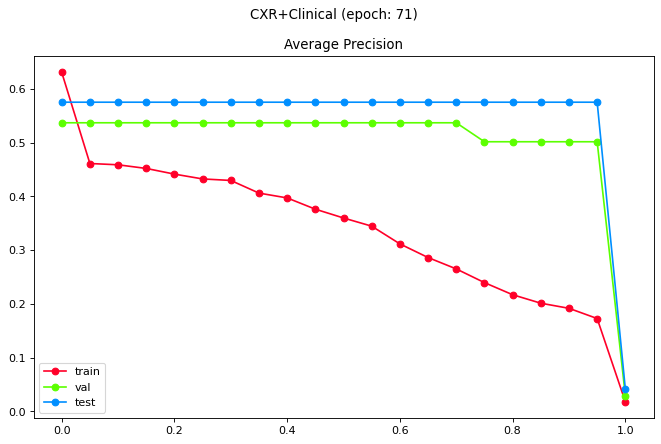

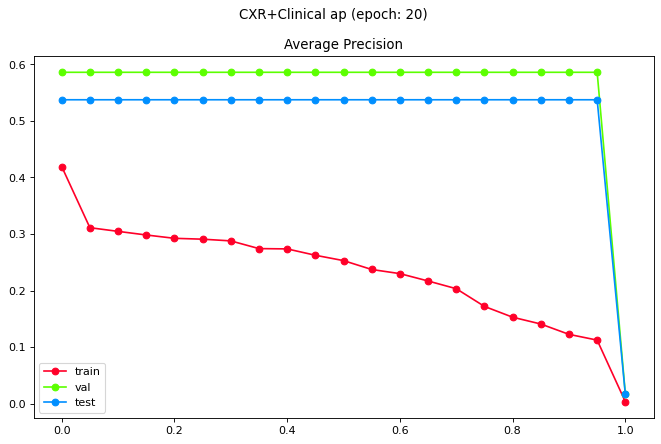

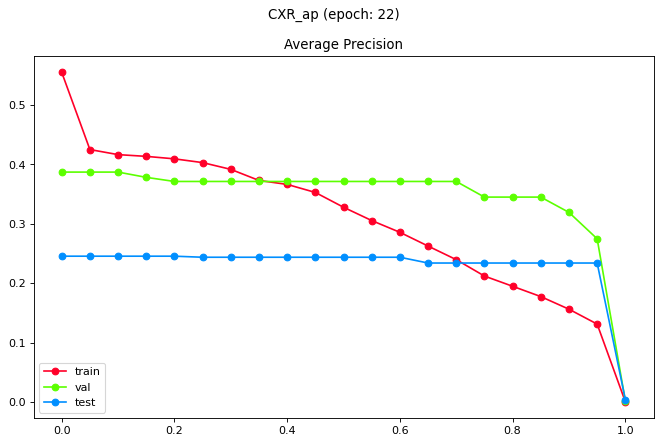

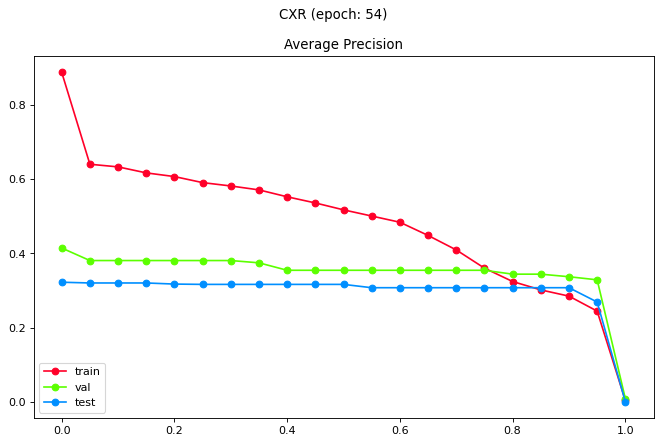

In [13]:
for model in [
    TrainedModels.CXR_Clinical_final,
    TrainedModels.CXR_Clinical_ap,
    TrainedModels.CXR_ap,
    TrainedModels.CXR_final,
]:
    _ = showModelOnDatasets(
        model, ["train", "val", "test"], figsize=(10, 6), score_thrs=0.3,
    )



====================Enlarged cardiac silhouette====================


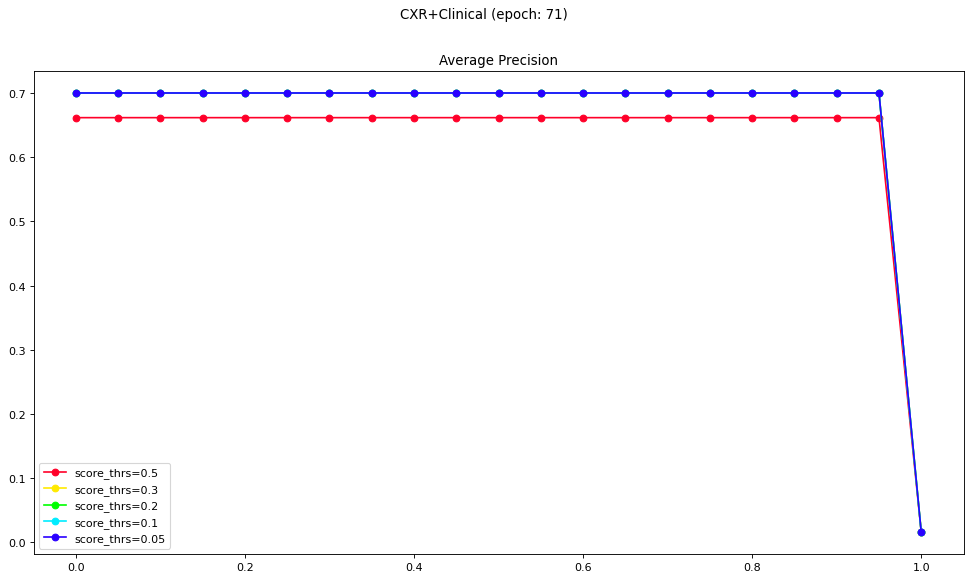

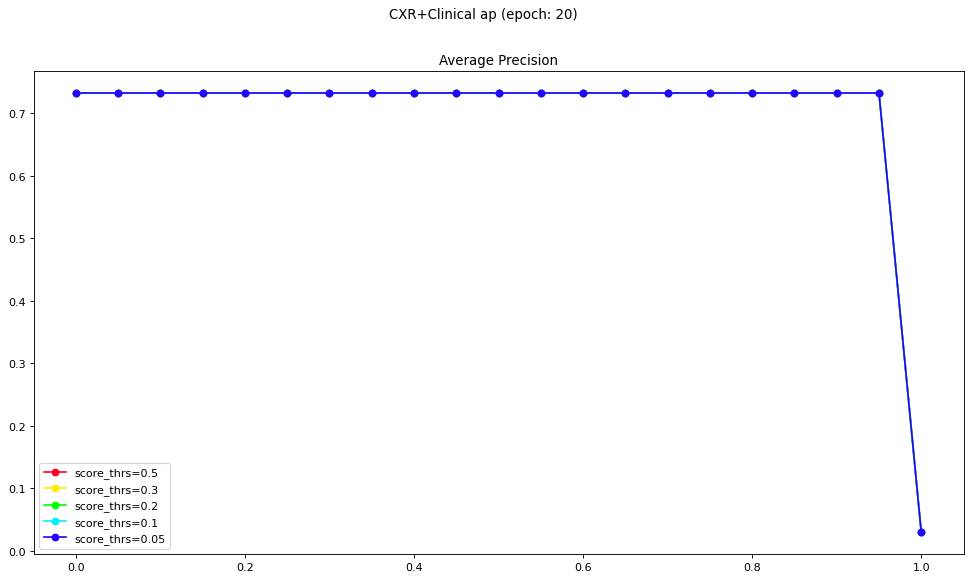

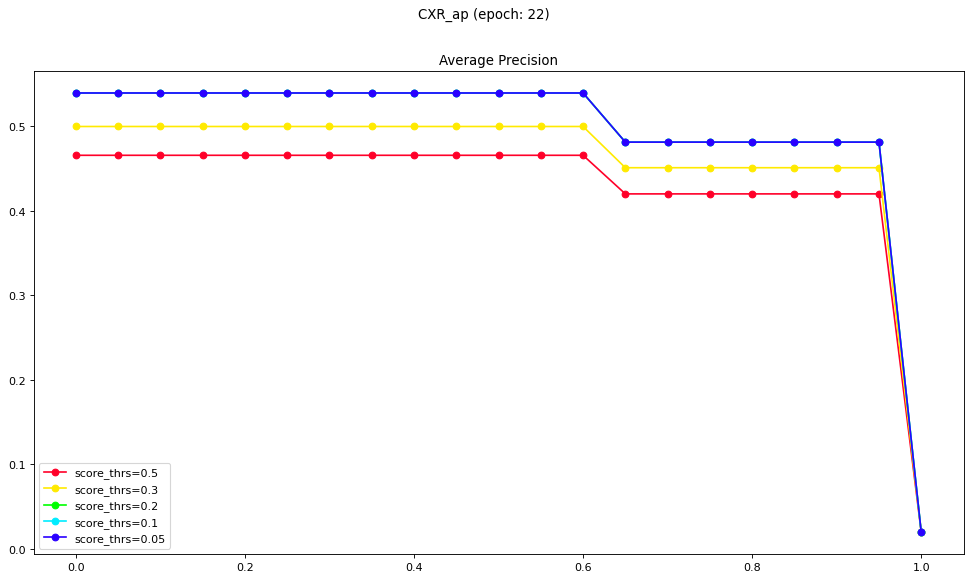

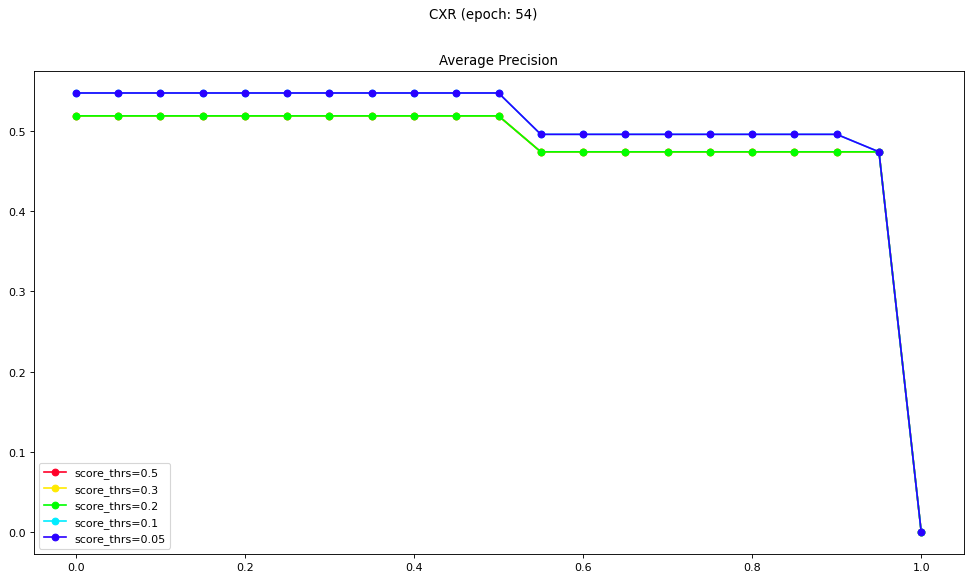

====================Atelectasis====================


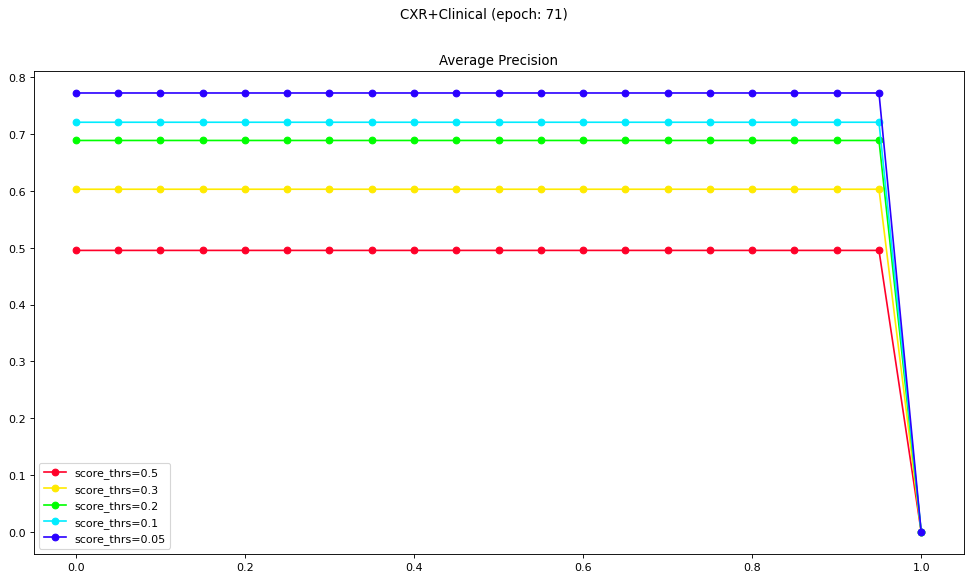

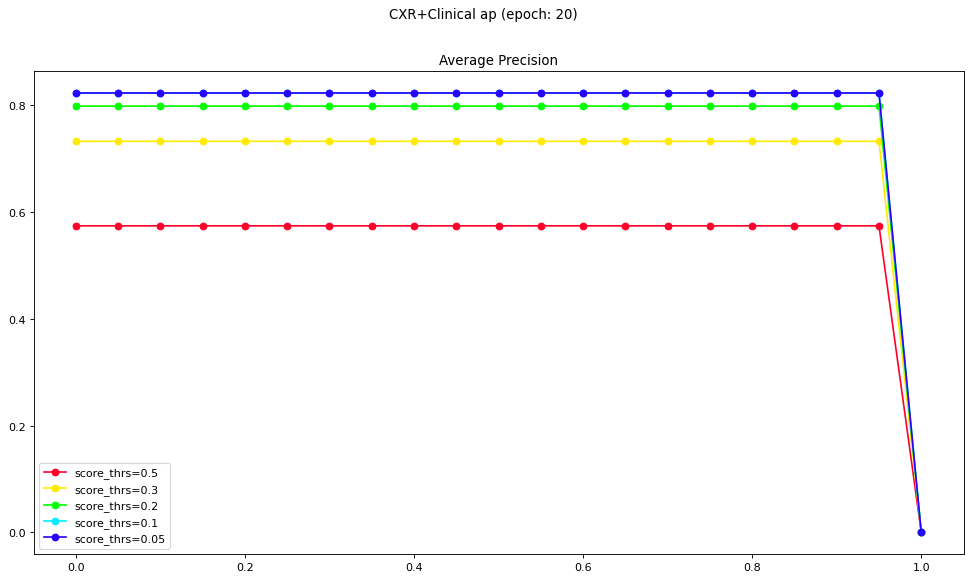

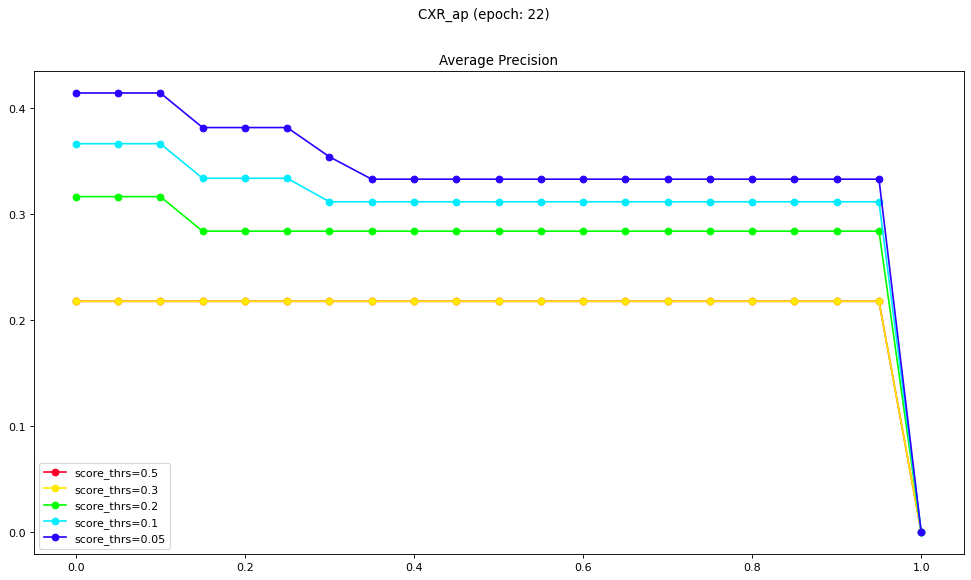

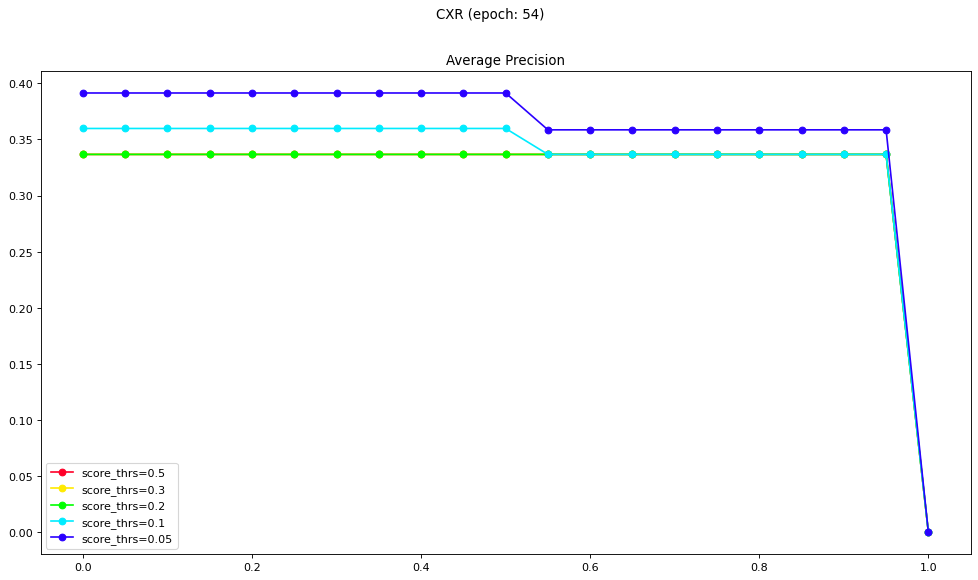

====================Pleural abnormality====================


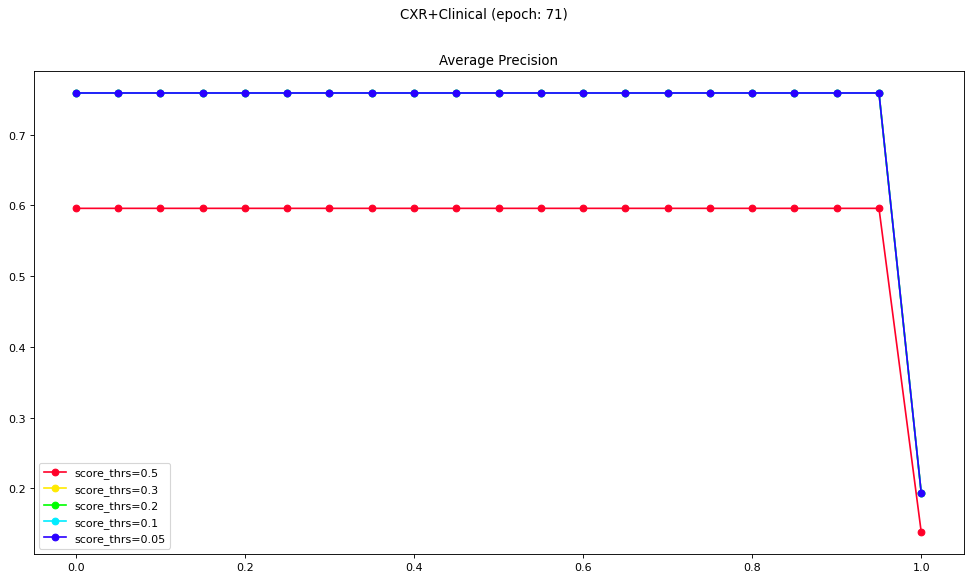

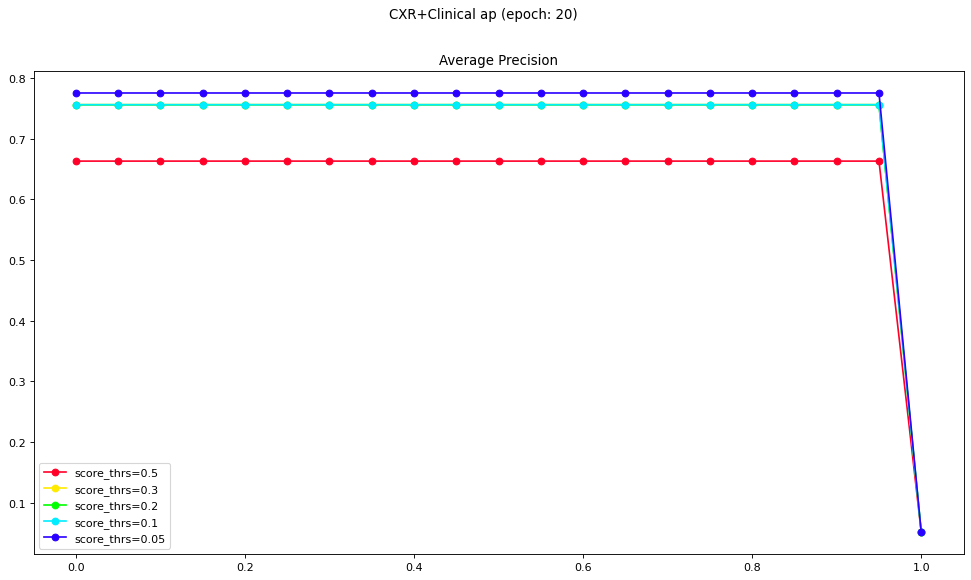

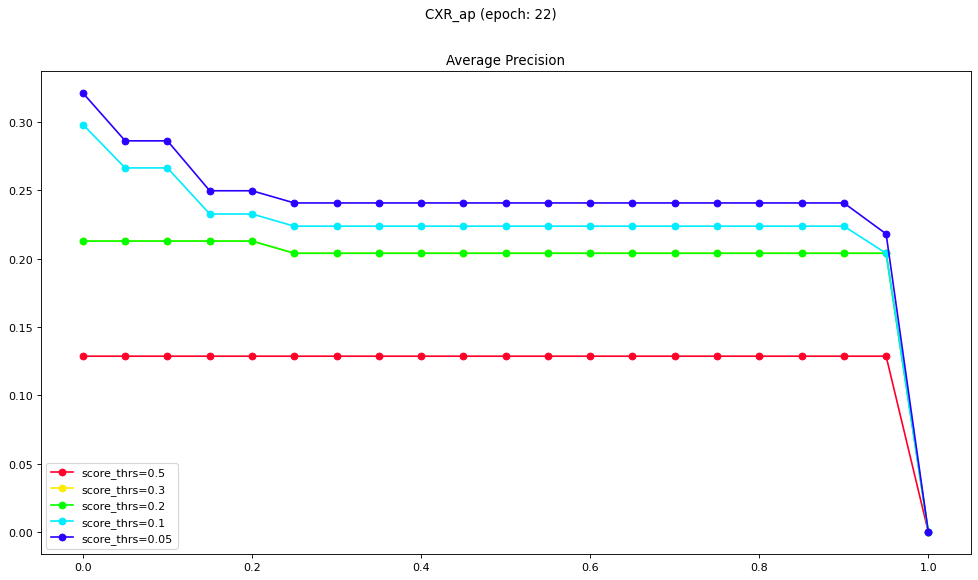

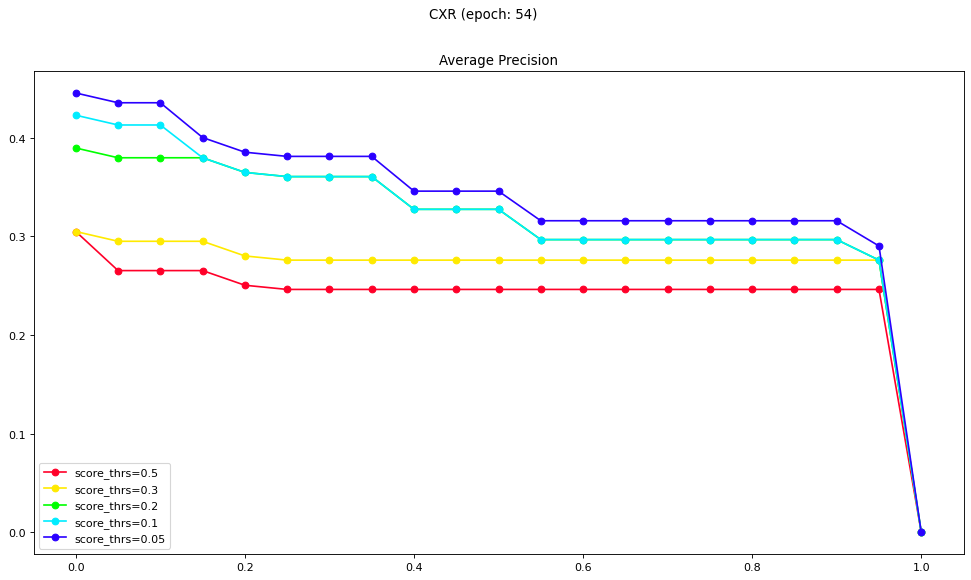

====================Consolidation====================


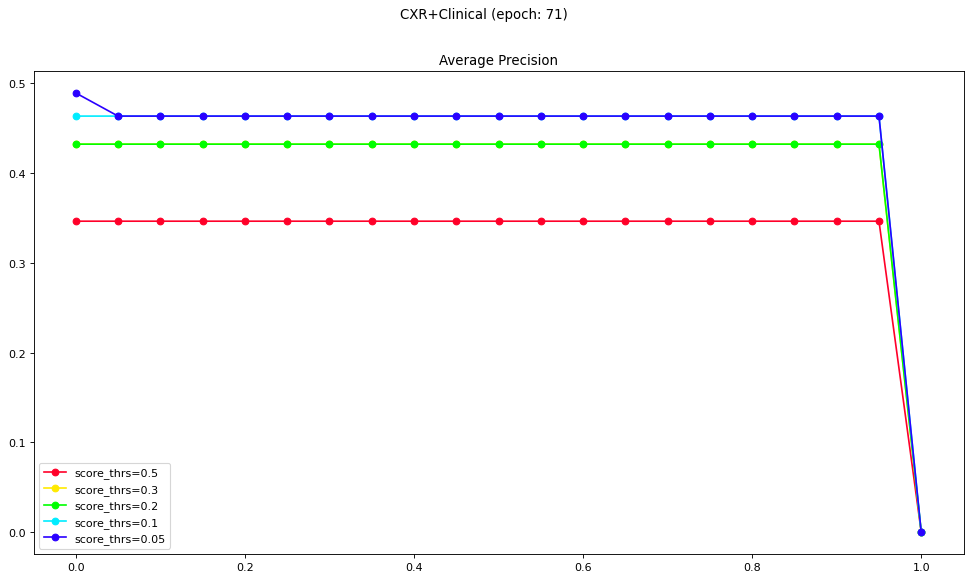

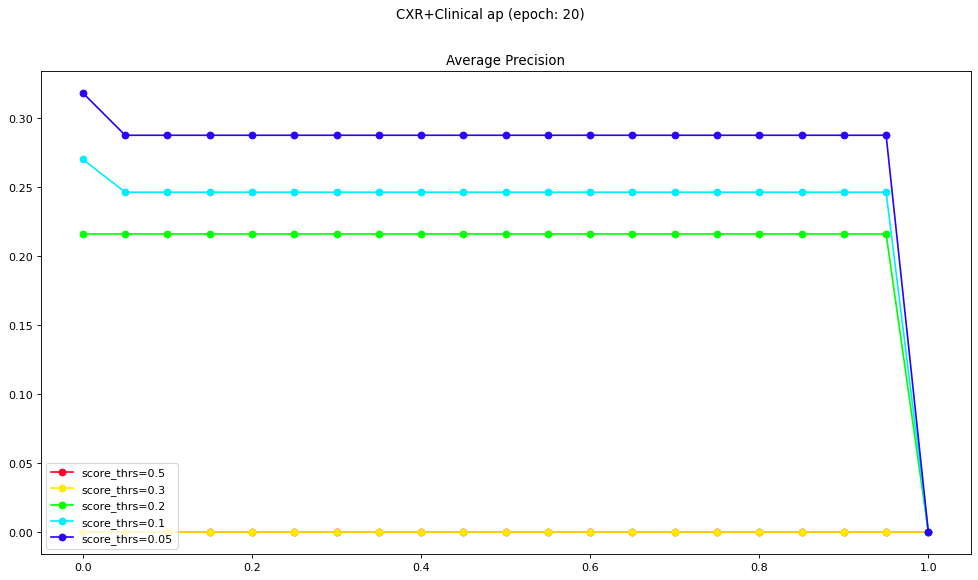

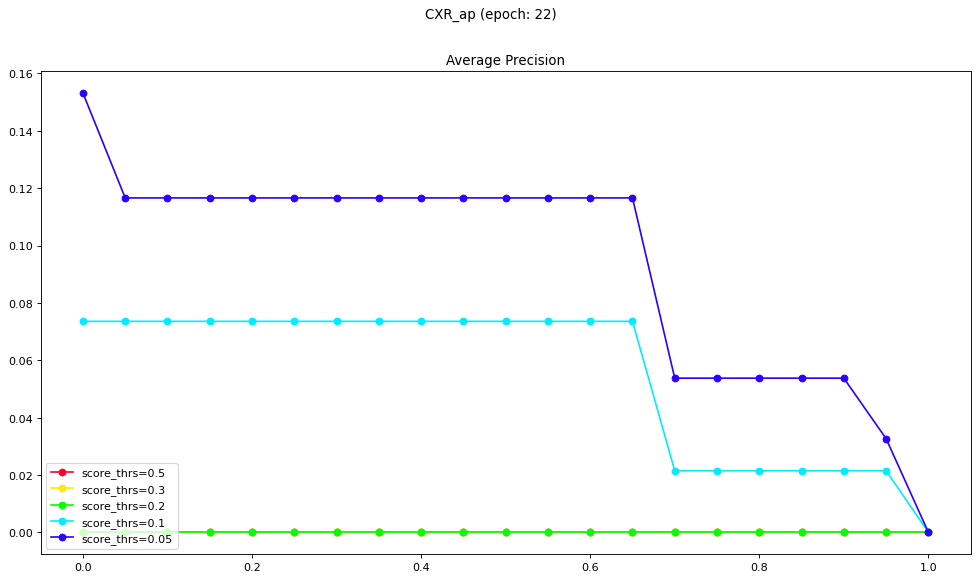

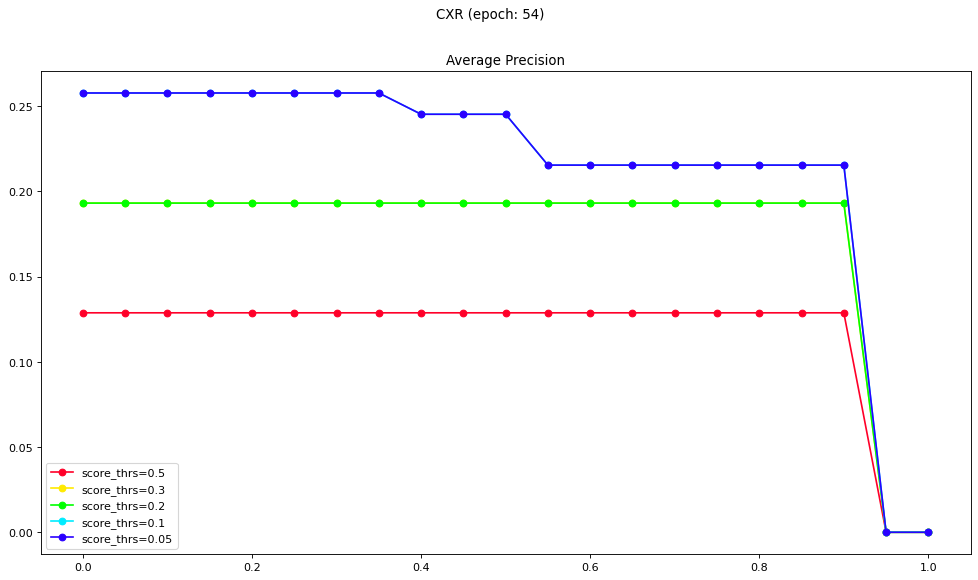

====================Pulmonary edema====================


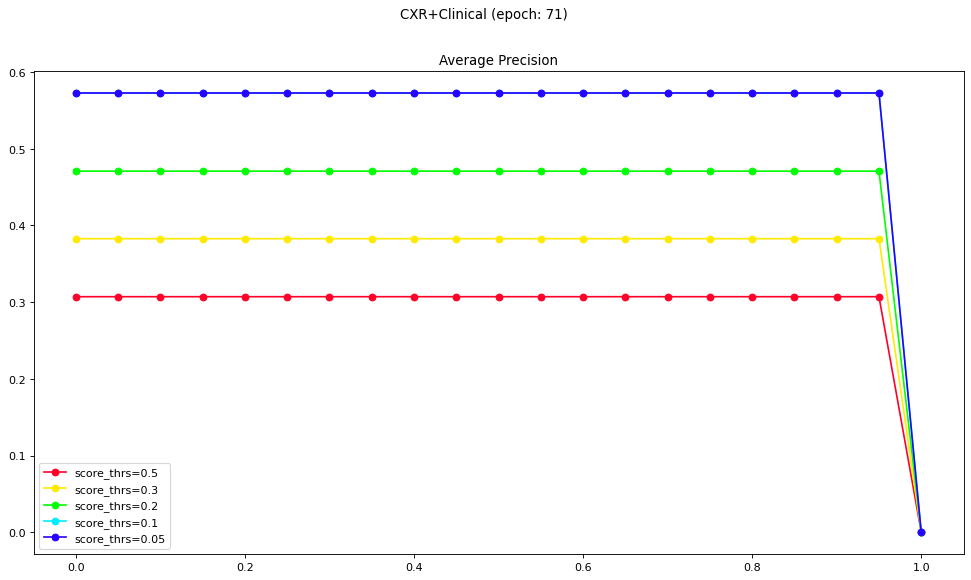

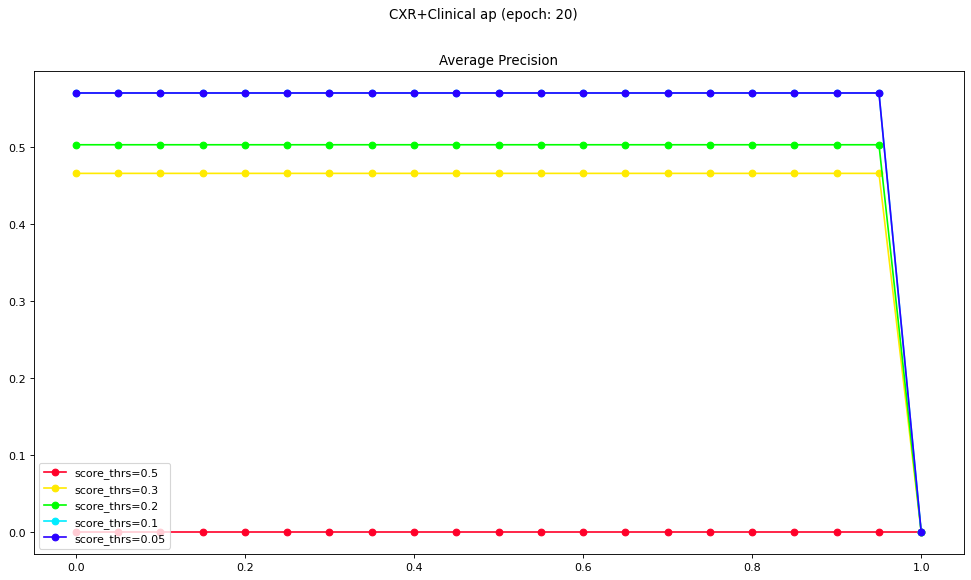

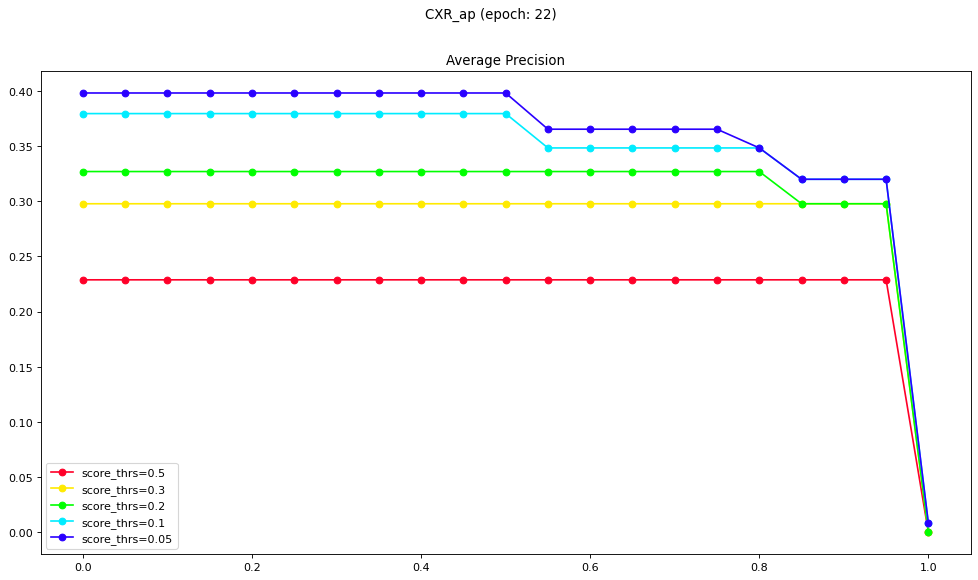

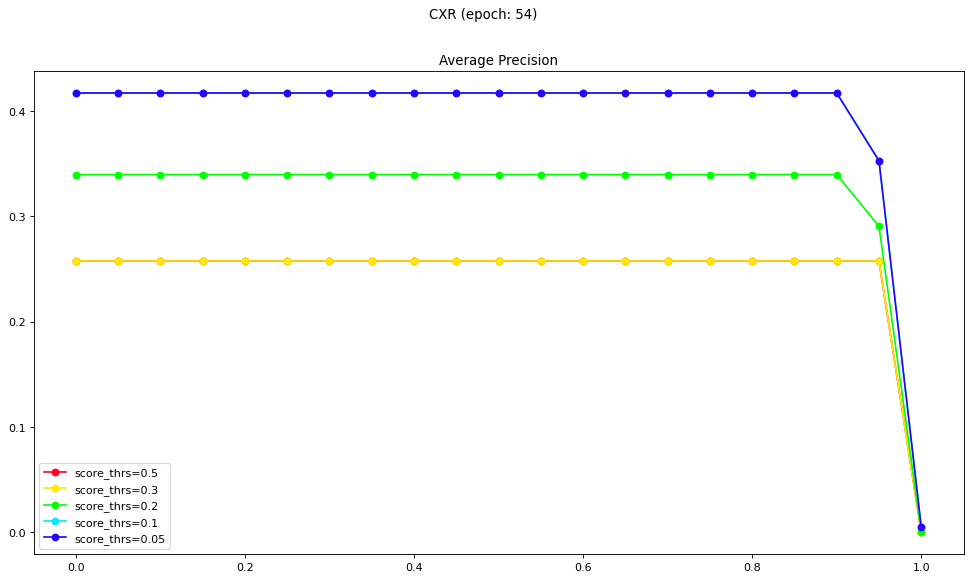

====================all====================


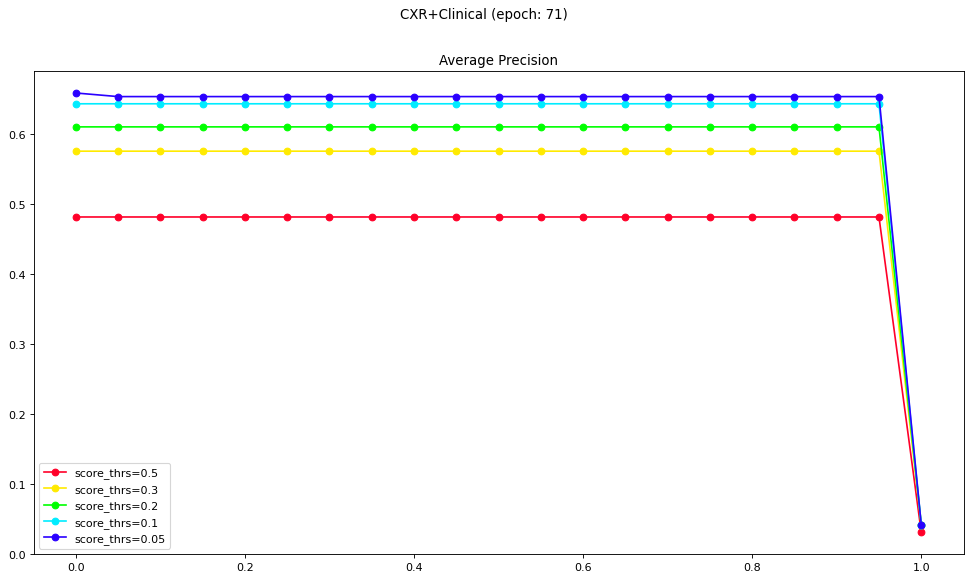

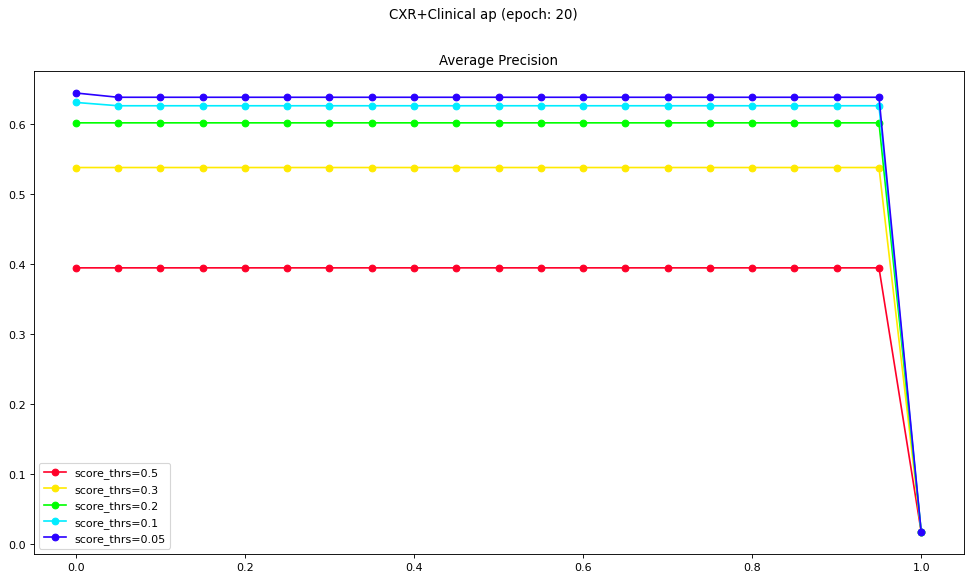

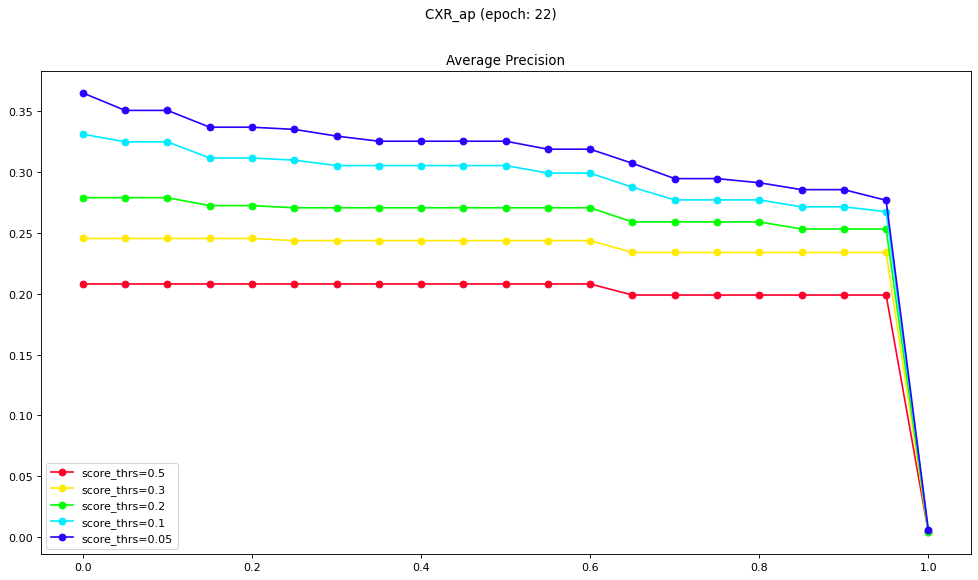

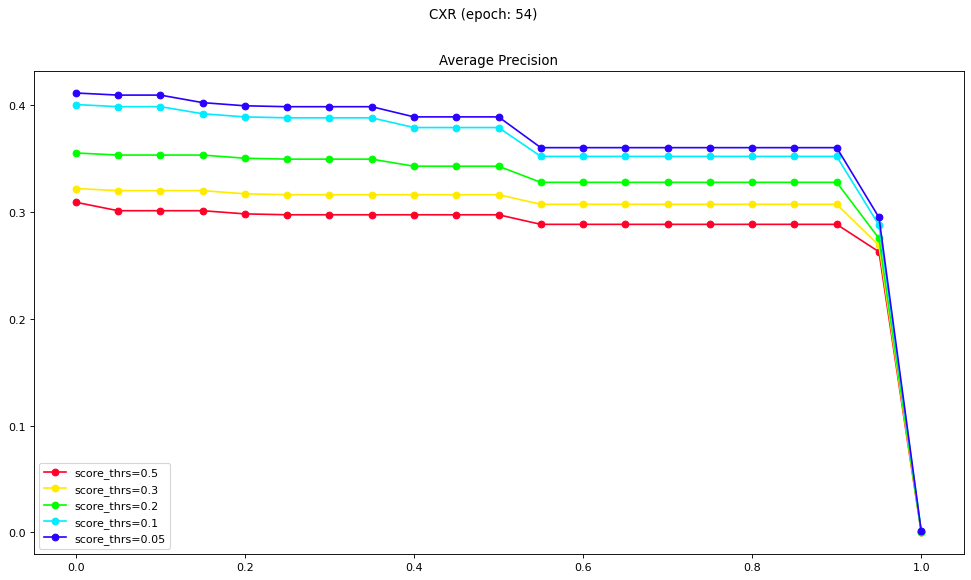

In [21]:
for disease in DEFAULT_REFLACX_LABEL_COLS + ['all']:
    print_f.print_title(disease)
    for model in [
        TrainedModels.CXR_Clinical_final,
        TrainedModels.CXR_Clinical_ap,
        TrainedModels.CXR_ap,
        TrainedModels.CXR_final,
    ]:
        showModelOnScoreThrs(
            model, "test", disease=disease,figsize=(15, 8),
        )

In [15]:
# all_datasets = ['train', 'val', 'test', 'our']
# all_diseases = DEFAULT_REFLACX_LABEL_COLS + ['all']

In [16]:
# for dataset in all_datasets:
#     print_f.print_block(f"{dataset} dataset")
#     for disease in all_diseases:
#         print_f.print_title(disease)
#         display(
#             get_thrs_evaluation_df(
#                 [
#                     # TrainedModels.with_clinical,
#                     # TrainedModels.with_clinical_final,
#                     TrainedModels.without_clinical,
#                     # TrainedModels.without_clinical_final,
#                     TrainedModels.with_clinical_lr3_200,
#                 ],
#                 dataset,
#                 disease=disease,
#             )
#         )


In [17]:
## Need to make predictions.

In [18]:
from collections import OrderedDict


def get_mAP_mAR(
    models: List[TrainedModels], datasets: List[str], score_thrs: float = 0.05
):

    labels_cols = DEFAULT_REFLACX_LABEL_COLS + ["all"]
    # score_thrs = 0.05

    all_df = {d: {} for d in labels_cols}

    for disease_str in labels_cols:
        for select_model in models:
            model_path = select_model.value
            eval_df = pd.read_csv(
                os.path.join(
                    "eval_results",
                    f"{model_path}_{disease_str}_score_thrs{score_thrs}.csv",
                ),
                index_col=0,
            )
            all_df[disease_str][model_path] = eval_df

    # eval_dataset = 'val' # ['test', 'val', 'our']

    for eval_dataset in datasets:
        model_dfs = OrderedDict({})

        for select_model in models:
            model_path = select_model.value
            model_name = str(select_model).split(".")[-1]
            # Pick dataset

            model_eval = []
            for disease_str in labels_cols:
                model_eval.append(
                    {
                        **dict(
                            all_df[disease_str][model_path][
                                all_df[disease_str][model_path]["dataset"]
                                == eval_dataset
                            ].iloc[0]
                        ),
                        "disease": disease_str,
                    }
                )

            model_dfs[model_name] = pd.DataFrame(model_eval)[
                ["disease", f"AP@[IoBB = 0.50:0.95]", f"AR@[IoBB = 0.50:0.95]"]
            ]

        for idx, k in enumerate(model_dfs.keys()):
            if idx == 0:
                # create the merged df
                merged_df = model_dfs[k].copy()
                merged_df.columns = [
                    "disease" if c == "disease" else f"{c}_{k}"
                    for c in merged_df.columns
                ]
            else:
                df = model_dfs[k].copy()
                df.columns = [
                    "disease" if c == "disease" else f"{c}_{k}" for c in df.columns
                ]
                merged_df = merged_df.merge(df, "left", on="disease",)

        print_f.print_title(f"Dataset [{eval_dataset}]")
        display(merged_df)

        merged_df.to_csv(f"{eval_dataset}_dataset_class_ap_score_thrs_{score_thrs}.csv")

        


In [19]:
get_mAP_mAR(
    models=TrainedModels,
    datasets=["train", "val", "test", "our"],
    score_thrs= 0.05
)

====================Dataset [train]====================


,disease,AP@[IoBB = 0.50:0.95]_without_clinical,AR@[IoBB = 0.50:0.95]_without_clinical,AP@[IoBB = 0.50:0.95]_with_clinical_lr3_200,AR@[IoBB = 0.50:0.95]_with_clinical_lr3_200,AP@[IoBB = 0.50:0.95]_CXR_Clinical_ap,AR@[IoBB = 0.50:0.95]_CXR_Clinical_ap,AP@[IoBB = 0.50:0.95]_CXR_Clinical_final,AR@[IoBB = 0.50:0.95]_CXR_Clinical_final,AP@[IoBB = 0.50:0.95]_CXR_ap,AR@[IoBB = 0.50:0.95]_CXR_ap,AP@[IoBB = 0.50:0.95]_CXR_final,AR@[IoBB = 0.50:0.95]_CXR_final
0,Enlarged cardiac silhouette,0.433911,0.591129,0.360912,0.634677,0.394321,0.638710,0.460228,0.675000,0.430976,0.586290,0.470278,0.604032
1,Atelectasis,0.218491,0.502469,0.243919,0.481481,0.213071,0.520988,0.255468,0.516667,0.212294,0.439506,0.271407,0.492593
2,Pleural abnormality,0.146025,0.413492,0.209414,0.383333,0.244598,0.522222,0.330787,0.493651,0.148485,0.374603,0.224881,0.442857
3,Consolidation,0.033188,0.270149,0.018665,0.216418,0.065560,0.400000,0.129883,0.526866,0.065429,0.410448,0.336842,0.553731
4,Pulmonary edema,0.272714,0.632673,0.177154,0.450495,0.225876,0.498020,0.487545,0.694059,0.350453,0.558416,0.520153,0.669307
5,all,0.205924,0.469662,0.185519,0.441184,0.239148,0.532151,0.342777,0.589660,0.269994,0.503383,0.385454,0.570623


====================Dataset [val]====================


,disease,AP@[IoBB = 0.50:0.95]_without_clinical,AR@[IoBB = 0.50:0.95]_without_clinical,AP@[IoBB = 0.50:0.95]_with_clinical_lr3_200,AR@[IoBB = 0.50:0.95]_with_clinical_lr3_200,AP@[IoBB = 0.50:0.95]_CXR_Clinical_ap,AR@[IoBB = 0.50:0.95]_CXR_Clinical_ap,AP@[IoBB = 0.50:0.95]_CXR_Clinical_final,AR@[IoBB = 0.50:0.95]_CXR_Clinical_final,AP@[IoBB = 0.50:0.95]_CXR_ap,AR@[IoBB = 0.50:0.95]_CXR_ap,AP@[IoBB = 0.50:0.95]_CXR_final,AR@[IoBB = 0.50:0.95]_CXR_final
0,Enlarged cardiac silhouette,0.573300,0.854545,0.314494,0.672727,0.969472,1.000000,0.772041,0.954545,0.890395,0.945455,0.944752,1.000000
1,Atelectasis,0.208141,0.444444,0.408661,0.650000,0.612262,0.833333,0.524695,0.777778,0.325567,0.544444,0.283167,0.438889
2,Pleural abnormality,0.079893,0.364286,0.847798,0.928571,0.836031,1.000000,0.790135,1.000000,0.315078,0.550000,0.359601,0.492857
3,Consolidation,0.021216,0.142857,0.123921,0.428571,0.199010,0.857143,0.311663,1.000000,0.128660,0.514286,0.072984,0.357143
4,Pulmonary edema,0.423122,0.653846,0.445408,0.700000,0.855687,1.000000,0.901345,1.000000,0.563199,0.823077,0.307111,0.538462
5,all,0.261135,0.491996,0.428056,0.675974,0.695978,0.938095,0.659976,0.946465,0.444580,0.675452,0.393051,0.565470


====================Dataset [test]====================


,disease,AP@[IoBB = 0.50:0.95]_without_clinical,AR@[IoBB = 0.50:0.95]_without_clinical,AP@[IoBB = 0.50:0.95]_with_clinical_lr3_200,AR@[IoBB = 0.50:0.95]_with_clinical_lr3_200,AP@[IoBB = 0.50:0.95]_CXR_Clinical_ap,AR@[IoBB = 0.50:0.95]_CXR_Clinical_ap,AP@[IoBB = 0.50:0.95]_CXR_Clinical_final,AR@[IoBB = 0.50:0.95]_CXR_Clinical_final,AP@[IoBB = 0.50:0.95]_CXR_ap,AR@[IoBB = 0.50:0.95]_CXR_ap,AP@[IoBB = 0.50:0.95]_CXR_final,AR@[IoBB = 0.50:0.95]_CXR_final
0,Enlarged cardiac silhouette,0.429548,0.531579,0.311449,0.552632,0.732673,0.736842,0.700550,0.736842,0.498304,0.594737,0.498731,0.578947
1,Atelectasis,0.246315,0.428571,0.713493,0.857143,0.823215,1.000000,0.771532,1.000000,0.333026,0.500000,0.361803,0.435714
2,Pleural abnormality,0.112294,0.250000,0.766760,0.812500,0.775529,0.875000,0.758896,0.812500,0.238472,0.368750,0.316168,0.500000
3,Consolidation,0.224242,0.325000,0.174092,0.375000,0.287711,0.750000,0.463610,0.625000,0.076773,0.412500,0.196795,0.350000
4,Pulmonary edema,0.266760,0.562500,0.356582,0.625000,0.569866,0.750000,0.572369,0.750000,0.353155,0.587500,0.410437,0.493750
5,all,0.255832,0.419530,0.464475,0.644455,0.637799,0.822368,0.653391,0.784868,0.299946,0.492697,0.356787,0.471682


====================Dataset [our]====================


,disease,AP@[IoBB = 0.50:0.95]_without_clinical,AR@[IoBB = 0.50:0.95]_without_clinical,AP@[IoBB = 0.50:0.95]_with_clinical_lr3_200,AR@[IoBB = 0.50:0.95]_with_clinical_lr3_200,AP@[IoBB = 0.50:0.95]_CXR_Clinical_ap,AR@[IoBB = 0.50:0.95]_CXR_Clinical_ap,AP@[IoBB = 0.50:0.95]_CXR_Clinical_final,AR@[IoBB = 0.50:0.95]_CXR_Clinical_final,AP@[IoBB = 0.50:0.95]_CXR_ap,AR@[IoBB = 0.50:0.95]_CXR_ap,AP@[IoBB = 0.50:0.95]_CXR_final,AR@[IoBB = 0.50:0.95]_CXR_final
0,Enlarged cardiac silhouette,0.014221,0.087500,0.309104,0.666667,0.647158,0.916667,0.687669,0.875000,0.456805,0.570833,0.564803,0.666667
1,Atelectasis,0.020702,0.222222,0.171034,0.777778,0.122306,0.777778,0.355693,0.777778,0.099010,0.333333,0.172207,0.555556
2,Pleural abnormality,0.230363,0.388889,0.551876,0.777778,0.559138,0.777778,0.606158,0.722222,0.331974,0.388889,0.357261,0.444444
3,Consolidation,0.185269,0.285714,0.256083,0.500000,0.316596,0.500000,0.540907,0.785714,0.095089,0.357143,0.149168,0.492857
4,Pulmonary edema,0.000000,0.000000,0.277228,0.375000,0.128713,0.250000,0.244478,0.500000,0.000000,0.000000,0.000000,0.000000
5,all,0.090111,0.196865,0.313065,0.619444,0.354782,0.644444,0.486981,0.732143,0.196576,0.330040,0.248688,0.431905
